# Step 2 - Train the Neural Network

### Brief Description

Train Convolutional Autoencoder Neural Network for predicting the State-of-Lithiation (SOL) on constant C-rate discharge on NMC-Lithium Foil half cells.

### Microstructure Parameters
1:
- L: 176 um
- porosity: 0.52455
- tortuosity: 1.6444

### Settings
Inputs: 3R (including particle) surroundings
Labels: Just the particle

- Batch size: 64
- Optimizer: Nadam


## Import Packages

The first code block is to import the files and modules in the `examples` folder. In practice, if one has their configuration files in the top-level directory - in the directory where the data-processing and loader scripts live - then this first block could be excluded.

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('../../li2d'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from preprocess_ml_data import preprocess_ml_data

from utils.custom_keras import Custom_2D_ROI_MSE

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from math import ceil

## Load the Training/Validation/Test Datasets

We load Extract-Transform-Load (ETL) datasets ready to train neural networks in TensorFlow.

In [3]:
trn_dataset, val_dataset, test_dataset = preprocess_ml_data()

Metal device set to: Apple M1 Pro


2022-08-21 17:48:57.044840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-21 17:48:57.044944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Visualizing a Target Image from the Training Dataset

2022-08-21 17:48:57.651791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-21 17:48:57.844549: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-21 17:48:57.847825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(-0.5, 98.5, 98.5, -0.5)

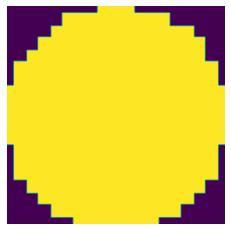

In [4]:
for inp, out in trn_dataset.take(1):
    img = inp[0]
        
plt.imshow(out[0])
plt.axis('off')

## Define the Neural Network

The broad classification of this neural network is a Convolutional Autoencoder. It has a downsampling area called the Encoder where the dimension of the images are reduced until the so-called "bottleneck". Afterwards, the images are upsampled in the Decoder.

This network effectively takes the porous media and attempts to predict the State-of-Lithiation in an intercalation host structure.

In [5]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        
        metadata = keras.Input(shape=(9,), name="metadata")
        
        inputShape = (height, width, depth)
        chanDim = -1
        
        inputs = keras.Input(shape=inputShape)
        x = inputs
        
        # loop over the number of filters
        for f in filters:
            x = layers.Conv2D(f, (3, 3), strides=2, activation="relu", padding="same")(x)
        
        # For reshaping later
        volumeSize = tf.keras.backend.int_shape(x)
        
        # flatten the network and then construct our latent vector
        x = layers.Flatten()(x)
        latent = layers.Dense(latentDim)(x)
        
        # Incorporate the metadata here
        appended = layers.Concatenate(axis=1)([latent, metadata])
        appended_out = layers.Dense(latentDim + metadata.shape[-1])(appended)
        
        # build the encoder model
        encoder = tf.keras.Model(inputs=[inputs, metadata], outputs=appended_out, name="encoder")
        
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = keras.Input(shape=(latentDim + metadata.shape[-1],))
        
        x = layers.Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = layers.Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        # loop over out number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, activation="relu", padding="same")(x)
            
        last = layers.Conv2DTranspose(filters=depth, kernel_size=3, activation="relu", padding="same")(x)
        last = tf.image.resize(last, (width, height))
        
        # build the decoder model
        decoder = keras.Model(latentInputs, last, name="decoder")
        
        # our autoencoder is the encoder + decoder
        autoencoder = keras.Model(
            inputs=[inputs, metadata], 
            outputs=decoder(encoder([inputs, metadata])),
            name="autoencoder",
        )
        
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

In [6]:
(
    encoder,
    decoder,
    autoencoder,
) = ConvAutoencoder.build(99, 99, 1, filters=(8, 16, 32, 64, 128, 256))

### Details of the Encoder, Decoder, and Full Neural Network

In [7]:
print(autoencoder.summary())

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 99, 99, 1)]  0           []                               
                                                                                                  
 metadata (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 encoder (Functional)           (None, 25)           410458      ['input_1[0][0]',                
                                                                  'metadata[0][0]']               
                                                                                                  
 decoder (Functional)           (None, 99, 99, 1)    1009857     ['encoder[0][0]']      

In [8]:
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 99, 99, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 8)    80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 25, 16)   1168        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 13, 13, 32)   4640        ['conv2d_1[0][0]']               
                                                                                            

In [9]:
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              26624     
                                                                 
 reshape (Reshape)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 64)       7379

## Specify Details for Training the Network

The loss function only considers an enscribed circle fitting an 99x99 pixel image.

Callbacks could be defined:
- EarlyStopping: the model does not have to complete all the user-specified epochs. Instead, if the validation loss ceases to decrease after the specified number of epochs by `patience` the training stops.
- ModelCheckpoint: save the model with the lowest validation loss

In [10]:
autoencoder.compile(loss=Custom_2D_ROI_MSE(1, 99, 10),
              optimizer='Nadam')

In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5),
    keras.callbacks.ModelCheckpoint(
        filepath="99x99 - Final Model.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = autoencoder.fit(
    trn_dataset,
    epochs=20,
    validation_data = val_dataset,
    callbacks=callbacks)

Epoch 1/20


2022-08-21 17:49:15.242887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - ETA: 0s - loss: 0.1186

2022-08-21 17:49:46.781505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 40s 172ms/step - loss: 0.1186 - val_loss: 0.0684
Epoch 2/20
194/194 [==============================] - 11s 56ms/step - loss: 0.0621 - val_loss: 0.0589
Epoch 3/20
194/194 [==============================] - 11s 55ms/step - loss: 0.0566 - val_loss: 0.0497
Epoch 4/20
194/194 [==============================] - 11s 54ms/step - loss: 0.0450 - val_loss: 0.0300
Epoch 5/20
194/194 [==============================] - 11s 56ms/step - loss: 0.0314 - val_loss: 0.0208
Epoch 6/20
194/194 [==============================] - 11s 56ms/step - loss: 0.0242 - val_loss: 0.0155
Epoch 7/20
194/194 [==============================] - 11s 57ms/step - loss: 0.0196 - val_loss: 0.0150
Epoch 8/20
194/194 [==============================] - 11s 56ms/step - loss: 0.0179 - val_loss: 0.0131
Epoch 9/20
194/194 [==============================] - 11s 55ms/step - loss: 0.0165 - val_loss: 0.0125
Epoch 10/20
194/194 [==============================] - 11s 57ms/step - loss: 0.0159 - val_lo

## Visualize the Loss Data Recorded During the Training Process

<Figure size 432x288 with 0 Axes>

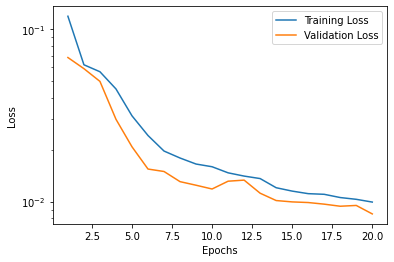

<Figure size 432x288 with 0 Axes>

In [12]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.figure()

## Evaluate the RMSE of the Datasets

This only considers pixels of where the State-of-Lithiation values live. Otherwise the other pixels are discarded.

In [15]:
from utils.image import circle_mask_as_vector_of_indices
import sys

mask = circle_mask_as_vector_of_indices(1, 99, 10)

def decorated(mask):
    
    indices = mask
    
    def just_conc(tensor):
        volume = tf.shape(tensor)
        dim = tf.reduce_prod(volume[1:])

        ret = tf.reshape(tensor, (-1, dim))
        ret = tf.gather(ret, indices, axis=1)

        return ret

    return just_conc


mask_circ = decorated(mask)

In [16]:
trn_lab_data = trn_dataset.map(lambda a, b: mask_circ(b))
trn_lab_data = trn_lab_data.unbatch()
trn_lab_data = np.array([thing for thing in trn_lab_data.as_numpy_iterator()])

val_lab_data = val_dataset.map(lambda a, b: mask_circ(b))
val_lab_data = val_lab_data.unbatch()
val_lab_data = np.array([thing for thing in val_lab_data.as_numpy_iterator()])

test_lab_data = test_dataset.map(lambda a, b: mask_circ(b))
test_lab_data = test_lab_data.unbatch()
test_lab_data = np.array([thing for thing in test_lab_data.as_numpy_iterator()])

In [17]:
def predict_and_rmse(
    model,
    dataset_loader,
    ground_truth_arr,
    mask,
):
    predictions = model.predict(dataset_loader)
    
    volume = predictions.shape
    dim = tf.reduce_prod(volume[1:])
    
    predictions = tf.reshape(predictions, (-1, dim))
    predictions = tf.gather(predictions, mask, axis=1)
    
    rmse = tf.reduce_mean(tf.square(predictions - ground_truth_arr))
    rmse = tf.sqrt(rmse)
    
    # predictions as vector, values are SoL in area of interest
    return predictions, rmse

### The Test set error is 9.06% after 20 epochs of training.

In [18]:
predictions, rmse = predict_and_rmse(
    autoencoder, 
    test_dataset,
    test_lab_data,
    mask,
)

print(rmse)

 2/65 [..............................] - ETA: 3s 

2022-08-21 17:53:33.269009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 1s 20ms/step
tf.Tensor(0.090565756, shape=(), dtype=float32)


### The Training and Validation set error is 9.01% and 9.22%, respectively, after 20 epochs of training.

In [19]:
trn_predictions, trn_rmse = predict_and_rmse(
    autoencoder, 
    trn_dataset,
    trn_lab_data,
    mask,
)

val_predictions, val_rmse = predict_and_rmse(
    autoencoder,
    val_dataset,
    val_lab_data,
    mask,
)

print(trn_rmse, val_rmse)

65/65 [==============================] - 1s 17ms/step
tf.Tensor(0.09010368, shape=(), dtype=float32) tf.Tensor(0.092161946, shape=(), dtype=float32)


## Visualize the Difference Between Prediction and Ground-Truth Data

The images should be a homogeneous colour with a value of 0 if there is a perfect match.

In [20]:
def sol_vector_to_img(
    sol_vector,
    img_size,
    mask,
):
    ret_im = np.zeros(img_size * img_size, dtype=np.float32)
    ret_im[mask] = sol_vector
    ret_im = np.reshape(ret_im, (img_size, img_size))
    
    return ret_im

In [21]:
def img_decorator(fn, img_size, mask):
    
    def ret_fn(sol_vector):
        return fn(
            sol_vector,
            img_size,
            mask,
        )
    
    return ret_fn

to_img = img_decorator(sol_vector_to_img, 99, mask)

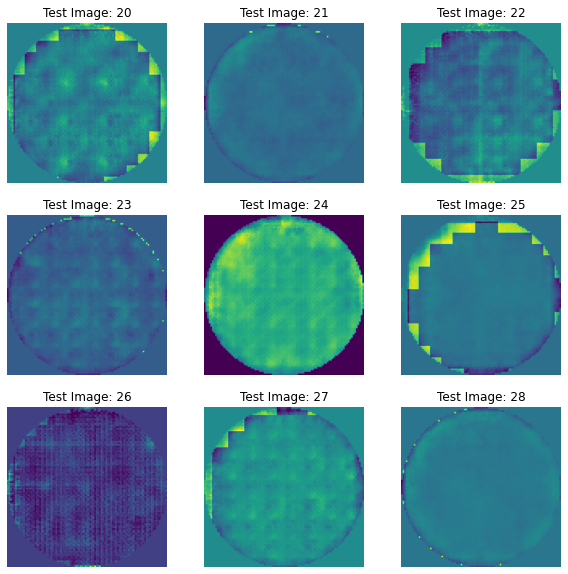

In [22]:
plt.figure(figsize=(10, 10))
for i in range(20, 29):
    ax = plt.subplot(3, 3, i + 1 - 20)
    plt.imshow(to_img(predictions[i]) - to_img(test_lab_data[i]))
    plt.title("Test Image: %d" % (i))
    plt.axis("off")
    